In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
%config InlineBackend.figure_format='retina'


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

df = pd.read_csv("static/data/beatles_lyrics_cleaned.csv")
df['lyrics'] = df['lyrics'].str.lower().replace('\n', ' ').str.replace('[^\w\s]', '')

stop_words = set(stopwords.words('english'))

# Tokenize and remove stopwords
def remove_stopwords(text):
    if isinstance(text, str):
        tokens = word_tokenize(text)
        tokens_without_sw = [word for word in tokens if word not in stop_words]
        return " ".join(tokens_without_sw)
    return ""


# Apply function
df['cleaned_lyrics'] = df['lyrics'].apply(remove_stopwords)

# Sentiment analysis
sia = SentimentIntensityAnalyzer()
df['sentiment'] = df['cleaned_lyrics'].apply(lambda x: sia.polarity_scores(x))
df['compound'] = df['sentiment'].apply(lambda x: x['compound'])


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/euansoutter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/euansoutter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/euansoutter/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/opt/anaconda3/envs/general/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  from ipykernel import kernelapp as app


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import numpy as np

# Initialize a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the documents
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_lyrics'][:20])

labels = [f"{song}" for song in df['title'][:20]]

# Compute the cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Define a similarity threshold
similarity_threshold = 0.2

# Create a mask to filter out lower similarity scores and self-comparisons
mask = (cosine_sim > similarity_threshold) & (np.eye(len(cosine_sim)) == 0)

# Apply the mask to the cosine similarity matrix
filtered_cosine_sim = np.where(mask, cosine_sim, np.nan)

# Convert the filtered matrix back to a DataFrame for easier handling
filtered_cosine_sim_df = pd.DataFrame(filtered_cosine_sim, index=labels, columns=labels)

# Convert to a DataFrame for better readability
cosine_sim_df = pd.DataFrame(filtered_cosine_sim_df)

In [3]:
tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df.max().sort_values()

31          0.074192
judge       0.074192
lips        0.074192
noise       0.074192
painting    0.074192
              ...   
lullaby     0.707107
yeah        0.734053
ahh         0.833333
heavy       0.958499
love        1.000000
Length: 212, dtype: float64

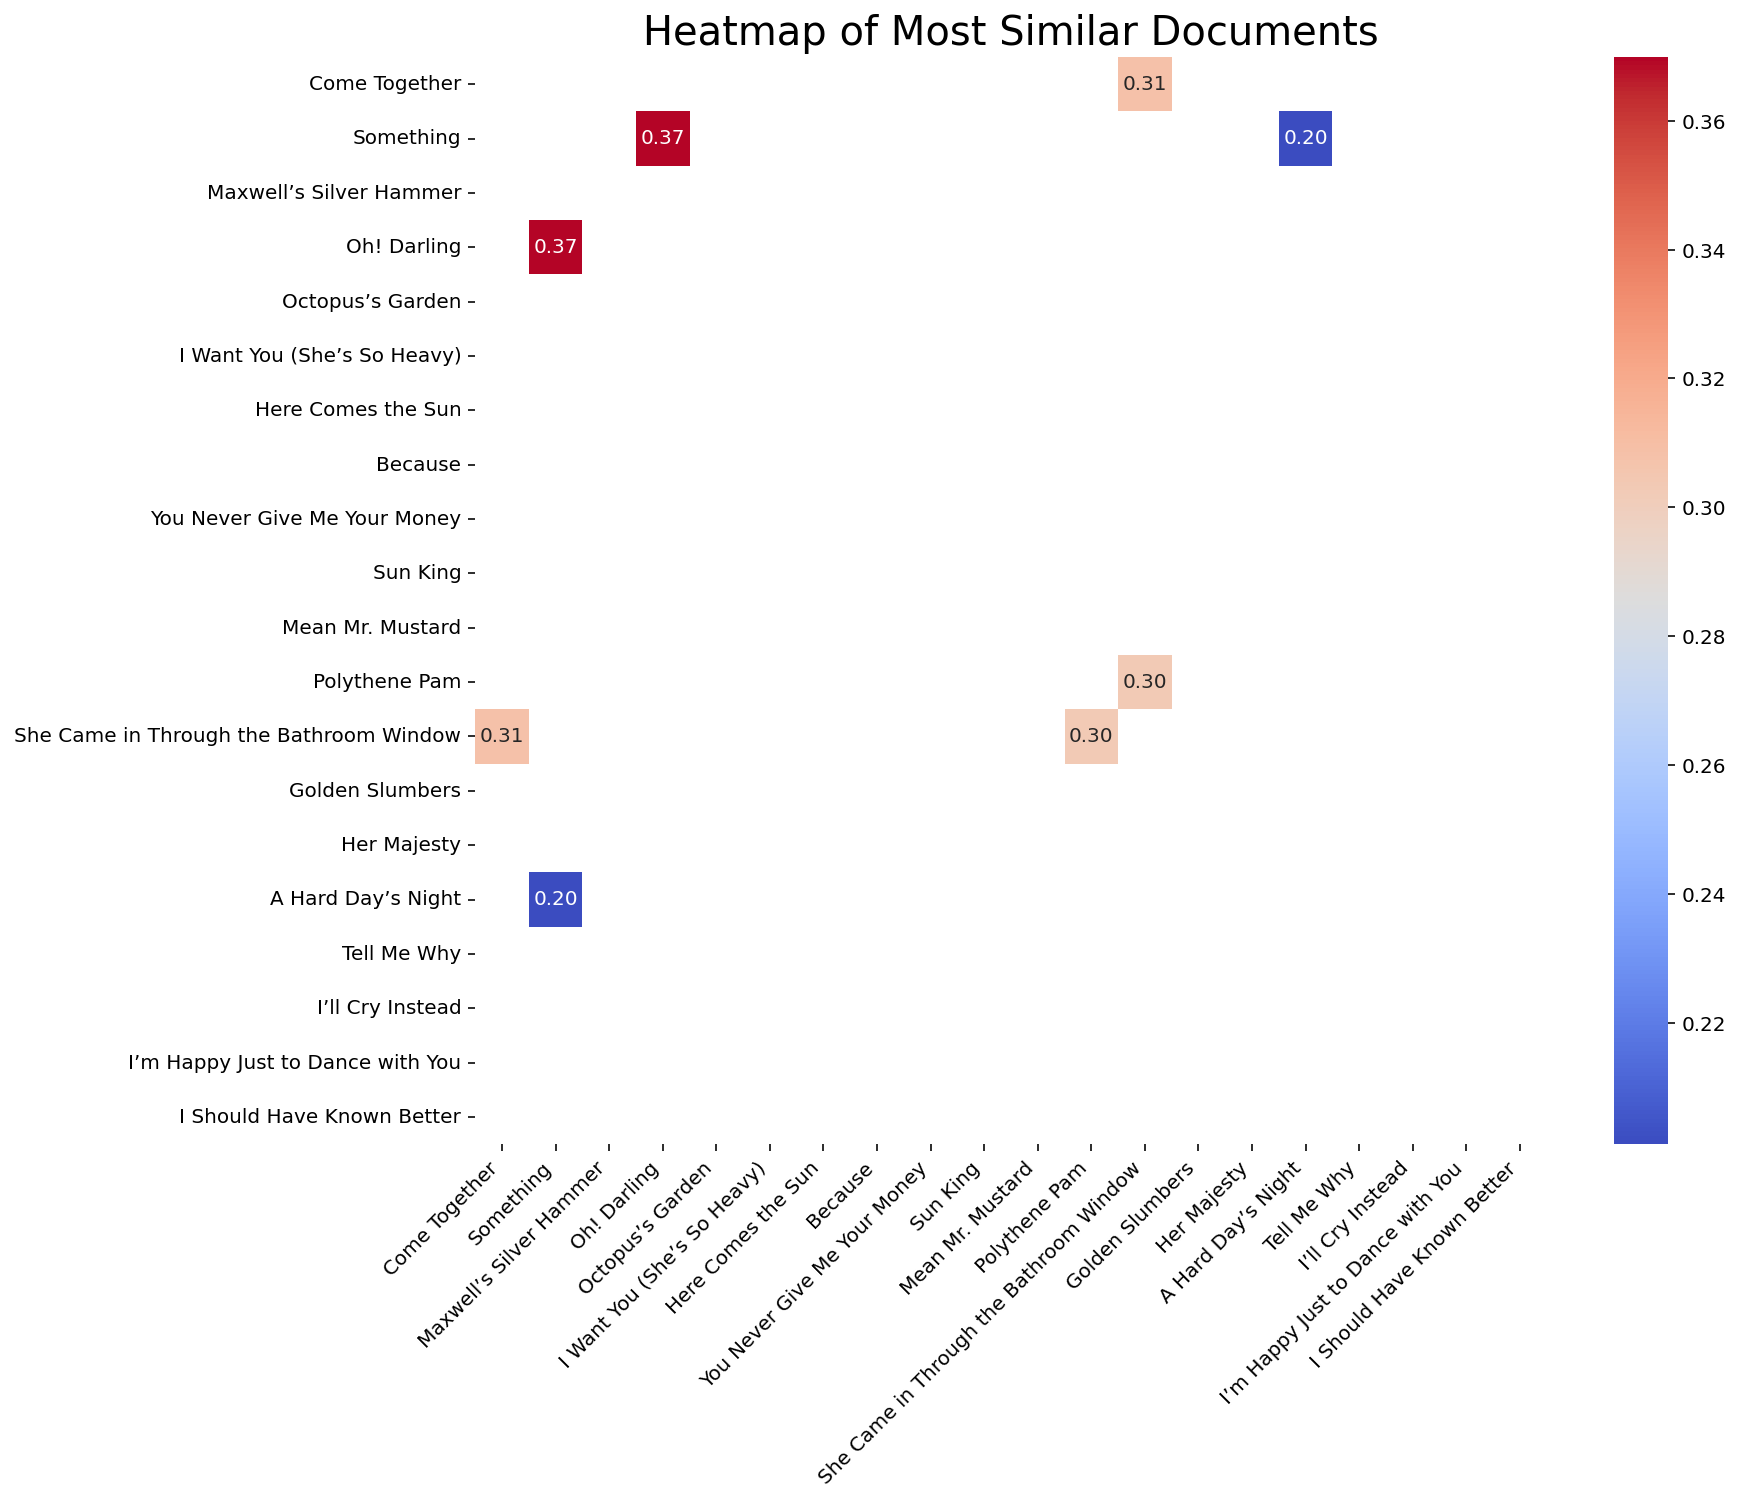

In [4]:

# Visualize the filtered similarity matrix
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_cosine_sim_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Heatmap of Most Similar Songs', fontsize=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

In [14]:
import pandas as pd
from transformers import BertModel, BertTokenizer
import torch
from sklearn.metrics.pairwise import cosine_similarity

# Load BERT tokenizer and model
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Tokenize and encode the documents for BERT
encoded_input = tokenizer(df['cleaned_lyrics'][:20].tolist(), padding=True, truncation=True, return_tensors='pt')

# Generate embeddings
with torch.no_grad():
    outputs = model(**encoded_input)
embeddings = outputs.last_hidden_state[:, 0, :].numpy()  # Get embeddings of the [CLS] token

# Compute cosine similarity matrix
cosine_sim = cosine_similarity(embeddings)

# Note: `similarity_matrix` is a 2D numpy array with cosine similarity values between documents.
# For example, similarity_matrix[i, j] is the similarity between documents i and j.


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


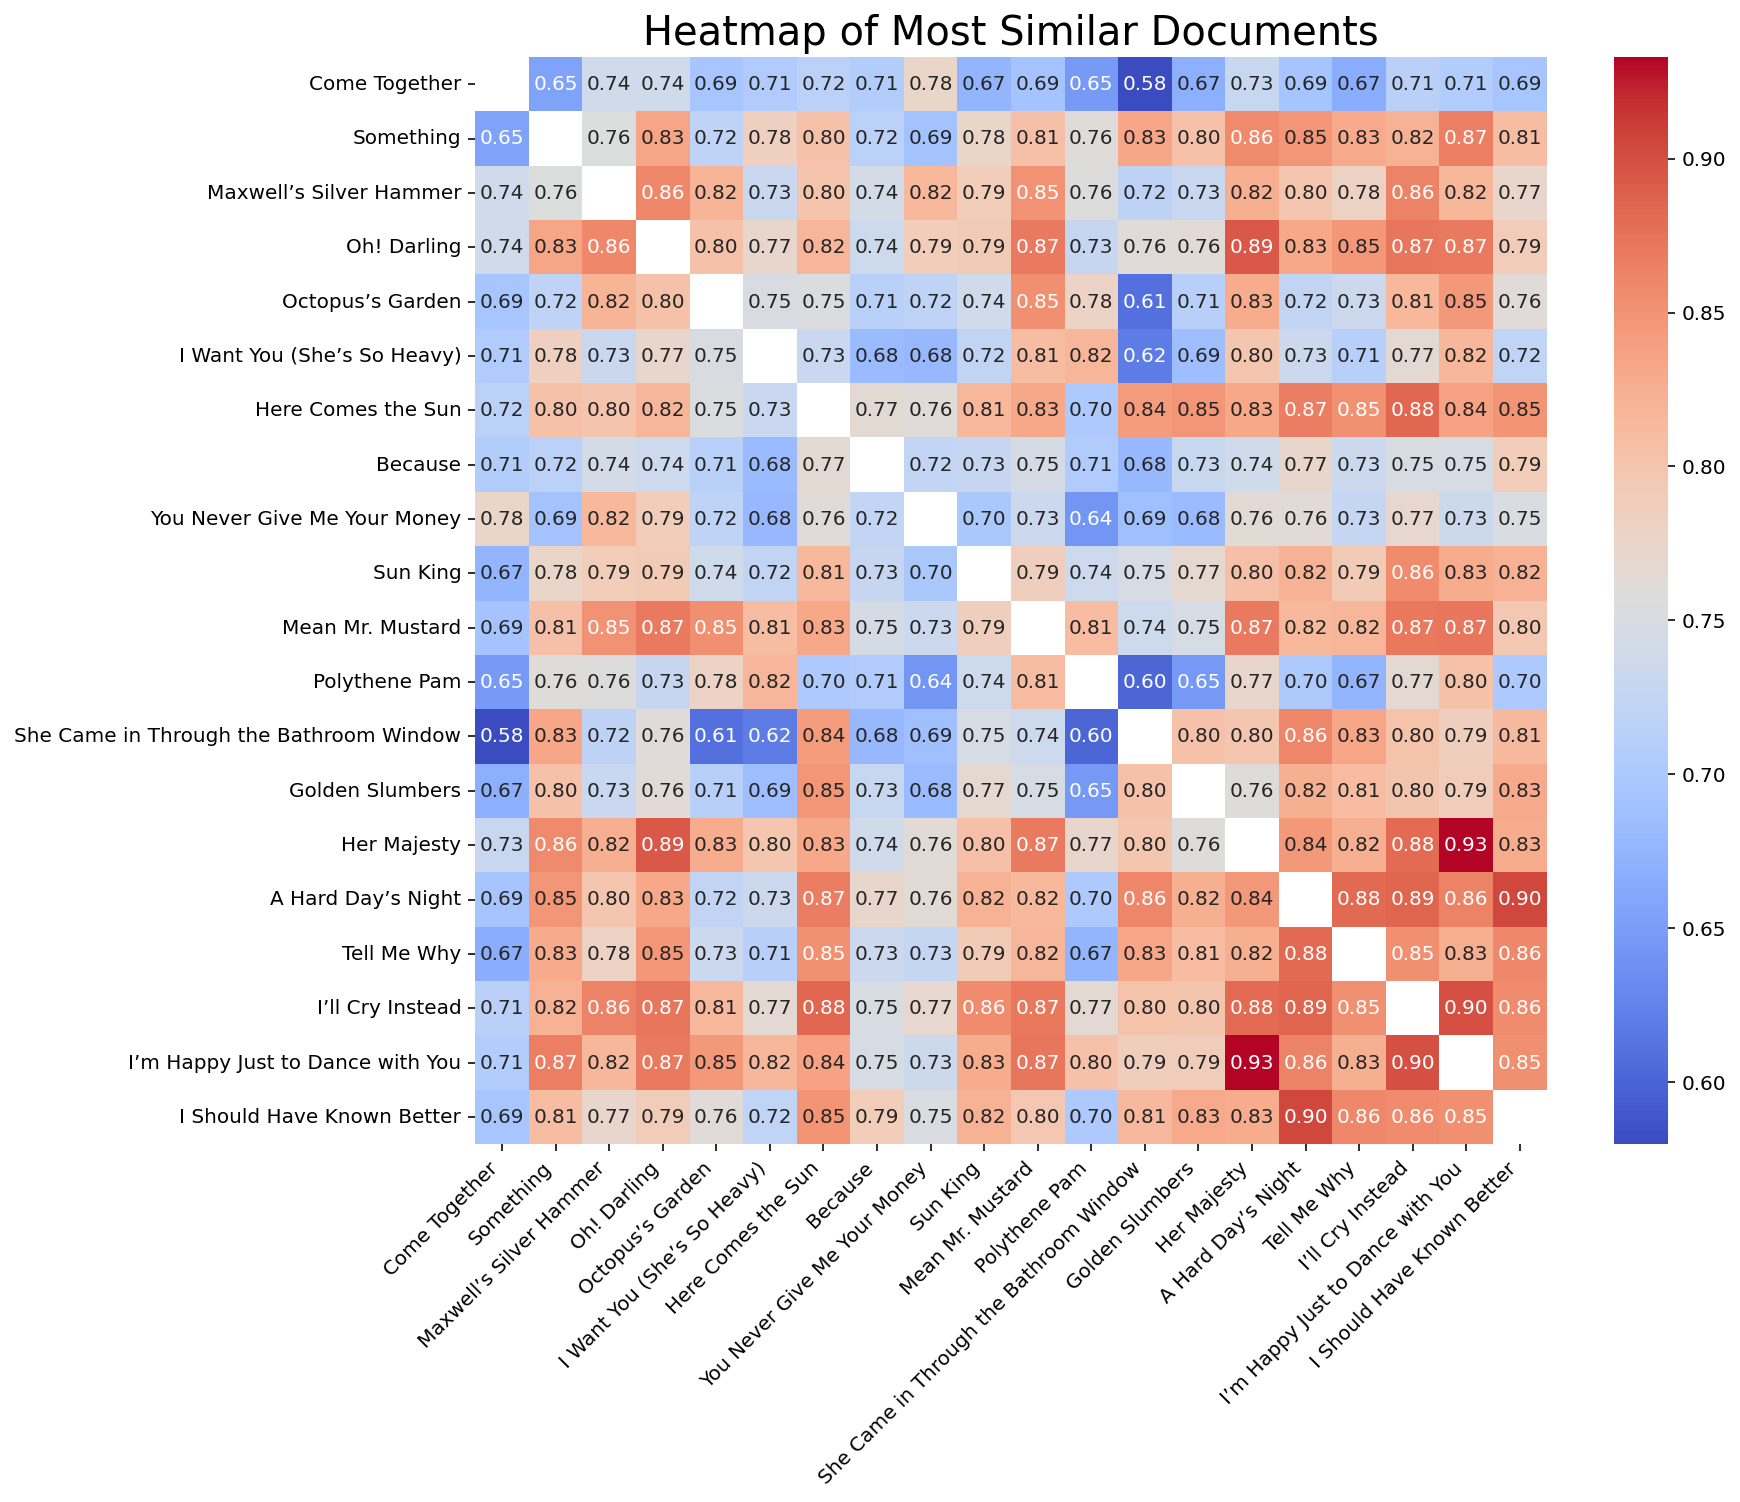

In [15]:
labels = [f"{song}" for song in df['title'][:20]]

# Define a similarity threshold
similarity_threshold = 0.2

# Create a mask to filter out lower similarity scores and self-comparisons
mask = (cosine_sim > similarity_threshold) & (np.eye(len(cosine_sim)) == 0)

# Apply the mask to the cosine similarity matrix
filtered_cosine_sim = np.where(mask, cosine_sim, np.nan)

# Convert the filtered matrix back to a DataFrame for easier handling
filtered_cosine_sim_df = pd.DataFrame(filtered_cosine_sim, index=labels, columns=labels)

# Convert to a DataFrame for better readability
cosine_sim_df = pd.DataFrame(filtered_cosine_sim_df)

# Visualize the filtered similarity matrix
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_cosine_sim_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Heatmap of Most Similar Songs', fontsize=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

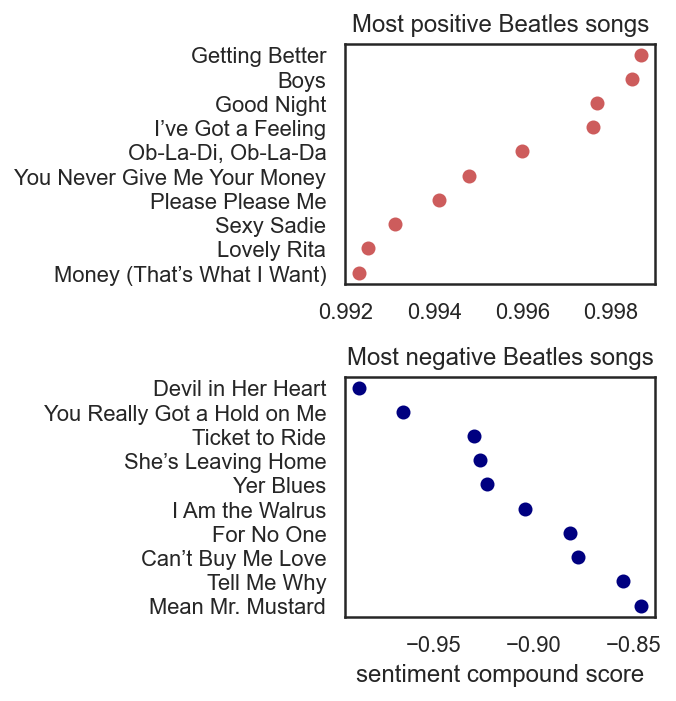

In [32]:
fig, ax = plt.subplots(figsize = (5, 5), nrows = 2)

df_low = df.sort_values('compound', ascending=True)[:10]
df_high = df.sort_values('compound', ascending=True)[-10:]

ax[0].plot(df_high.compound, df_high.title, 'o', color = 'indianred')
ax[0].set(title = 'Most positive Beatles songs')
ax[1].plot(df_low.compound, df_low.title, 'o', color = 'navy')
ax[1].set(title = 'Most negative Beatles songs',
          xlabel = 'sentiment compound score')
ax[1].invert_yaxis()


plt.tight_layout()
plt.savefig('static/sentiment.jpg', dpi = 400)

In [33]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel

def preprocess_text(text):
    # Tokenize and remove punctuation
    tokens = word_tokenize(text.lower())
    # Remove stopwords
    filtered_tokens = [w for w in tokens if w not in stop_words]
    return filtered_tokens

df['processed_lyrics'] = df['lyrics'].apply(preprocess_text)

dictionary = corpora.Dictionary(df['processed_lyrics'])
corpus = [dictionary.doc2bow(text) for text in df['processed_lyrics']]

num_topics = 5  # Adjust this according to your needs
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

topics = lda_model.print_topics(num_words=15)

for topic in topics:
    print(topic)

def get_dominant_topic(text):
    bow = dictionary.doc2bow(text)
    topics = sorted(lda_model.get_document_topics(bow), key=lambda x: x[1], reverse=True)
    return topics[0][0]

df['dominant_topic'] = df['processed_lyrics'].apply(get_dominant_topic)



(0, '0.051*"much" + 0.040*"want" + 0.034*"yeah" + 0.032*"thats" + 0.032*"better" + 0.030*"oh" + 0.018*"ah" + 0.017*"time" + 0.015*"getting" + 0.014*"got" + 0.014*"everybody" + 0.013*"da" + 0.011*"mccartney" + 0.011*"paul" + 0.010*"ive"')
(1, '0.079*"together" + 0.050*"la" + 0.018*"come" + 0.018*"see" + 0.015*"yeah" + 0.015*"wont" + 0.013*"say" + 0.011*"go" + 0.010*"bom" + 0.010*"hello" + 0.010*"ha" + 0.009*"cha" + 0.009*"cause" + 0.009*"girl" + 0.008*"sha"')
(2, '0.024*"good" + 0.023*"know" + 0.021*"roll" + 0.021*"mother" + 0.018*"bye" + 0.018*"submarine" + 0.018*"yellow" + 0.017*"tonight" + 0.013*"mystery" + 0.012*"guten" + 0.012*"morgen" + 0.012*"tour" + 0.011*"man" + 0.011*"hold" + 0.010*"baby"')
(3, '0.039*"na" + 0.035*"youre" + 0.030*"gon" + 0.030*"baby" + 0.029*"come" + 0.027*"girl" + 0.024*"dont" + 0.022*"yes" + 0.020*"lose" + 0.018*"like" + 0.017*"hold" + 0.016*"got" + 0.016*"let" + 0.015*"please" + 0.015*"youve"')
(4, '0.060*"yeah" + 0.045*"oh" + 0.038*"tit" + 0.028*"love" + 0

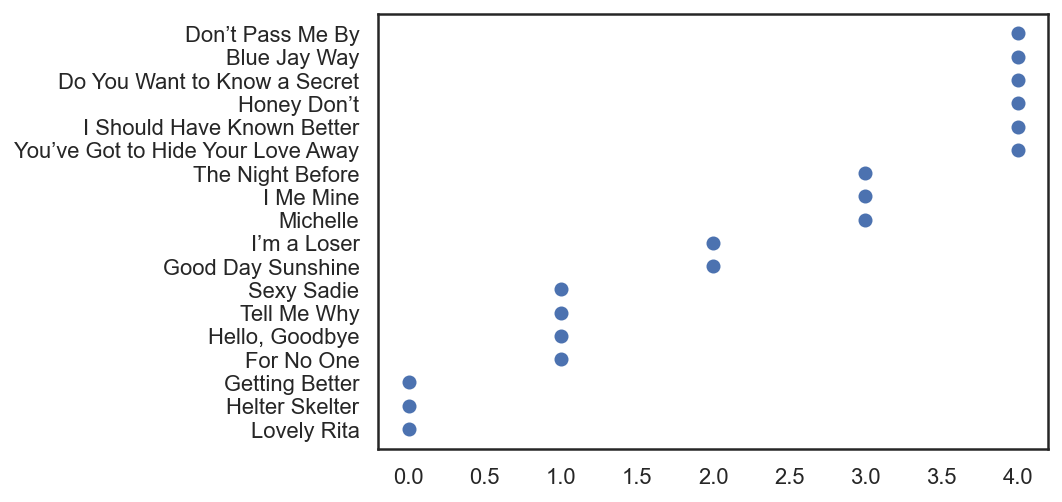

In [34]:
df_sorted = df.sort_values('dominant_topic')
plt.plot(df_sorted.dominant_topic[::10], df_sorted.title[::10], 'o')

In [35]:
df['cleaned_lyrics']

0      come together yeah come together yeah come tog...
1                           dont want leave know believe
2      bang bang maxwells silver hammer came upon hea...
3      oh darling leave ill never make alone believe ...
4      would shout swim coral lies beneath waves lies...
                             ...                        
168    think harmony little dark key youre correct th...
169    bom bom bom bompa bom sail ship bompa bom chop...
170    big man yeah walking park wigwam frightened da...
171    much ah much long blond hair eyes blue long bl...
172    need love together need love everybody need lo...
Name: cleaned_lyrics, Length: 173, dtype: object